## Initial setup

Load the packages and data sets.

In [32]:
import os
import pandas as pd
import matplotlib.pyplot as plt

PATH = r'/Users/ally/Desktop/UChicago/CREF'
df_test = pd.read_csv(os.path.join(PATH, 'CASP004-01_test-summary-per-bag.csv'))
df_product = pd.read_csv(os.path.join(PATH, 'CASP004-01_bag-product-setup.csv'))

## Initial data cleaning

- Calculte the average weight for items that have 3 weights but do not have average weight. 

In [5]:
# identify the columns for individual weights and mean weight
weight_columns = ['weight_1', 'weight_2', 'weight_3']
mean_weight_column = 'weight_mean_g'

# filter rows where all three weights are present, but the mean weight is not calculated
rows_to_update = df_test[weight_columns].notnull().all(axis=1) & df_test[mean_weight_column].isnull()

# calculate the mean for these rows
mean_weights = df_test.loc[rows_to_update, weight_columns].mean(axis=1)

# add the means in the data set
df_test.loc[rows_to_update, mean_weight_column] = mean_weights


## Data transformation

In [10]:
# only keep changed columns which can provide useful information
selected_columns = ['bag_ID', 'stage', 'bag_intact', 'bag_depth', 'product_name', 'photo_available', 'weight_mean_g', 'Product Notes']
changed_data = df_test[selected_columns]

# transform the long data into wide form
wide_changed_data = changed_data.pivot(index=['bag_ID', 'product_name'], 
                                       columns='stage', 
                                       values=['bag_intact', 'bag_depth', 'photo_available', 'weight_mean_g', 'Product Notes'])


In [11]:
# flaten the multilevel column indexes and make them lowercase
wide_changed_data.columns = ['_'.join(col) for col in wide_changed_data.columns.values]
wide_changed_data.columns = [col.lower() for col in wide_changed_data.columns]

# reset index to change bag_ID and product_name from indexes to columns
wide_changed_data = wide_changed_data.reset_index()

# writing to csv file  
wide_changed_data.to_csv('wide_trail_data.csv')  

wide_changed_data

,bag_ID,product_name,bag_intact_end,bag_intact_interval,bag_intact_start,bag_depth_end,bag_depth_interval,bag_depth_start,photo_available_end,photo_available_interval,photo_available_start,weight_mean_g_end,weight_mean_g_interval,weight_mean_g_start,product notes_end,product notes_interval,product notes_start
0,A-1,12 oz Hot cup / Soup bowl,True,True,True,Top depth,Top depth,Top depth,NaN,NaN,Y,NaN,NaN,8.11,NaN,NaN,NaN
1,A-1,16 oz PLA cold cup,True,True,True,Top depth,Top depth,Top depth,NaN,NaN,Y,NaN,NaN,14.58,NaN,NaN,NaN
2,A-1,Cutlery,True,True,True,Top depth,Top depth,Top depth,NaN,NaN,Y,NaN,NaN,4.75,NaN,NaN,NaN
3,A-1,Hot cup lid,True,True,True,Top depth,Top depth,Top depth,NaN,NaN,Y,NaN,NaN,3.57,NaN,NaN,NaN
4,A-1,Kraft control,True,True,True,Top depth,Top depth,Top depth,NaN,NaN,Y,NaN,NaN,2.85,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,C-6,Kraft control,True,True,True,Bottom depth,Bottom depth,Bottom depth,Y,NaN,Y,3.12,NaN,2.85,Several items stuck together and not decompose...,NaN,NaN
134,C-6,Large brown bag,True,True,True,Bottom depth,Bottom depth,Bottom depth,Y,NaN,Y,18.9,NaN,12.72,Several items stuck together and not decompose...,NaN,More detailed composition in word doc
135,C-6,Large natural clear colour bag,True,True,True,Bottom depth,Bottom depth,Bottom depth,Y,NaN,Y,8.97,NaN,8.4,Several items stuck together and not decompose...,NaN,NaN
136,C-6,Printed small bag with brown background and logo,True,True,True,Bottom depth,Bottom depth,Bottom depth,Y,NaN,Y,5.69,NaN,4.57,Several items stuck together and not decompose...,NaN,NaN


In [16]:
# fill in 0 for NAs in mean weight at endpoint because NA stands for completly decomposed, 
# except for bag A-5 and A-6 because they are missing as noted

def fill_na_weight(row):
    if row['bag_ID'] in ['A-5', 'A-6']: 
        return row['weight_mean_g_end']
    else:
        return 0 if pd.isna(row['weight_mean_g_end']) else row['weight_mean_g_end']

wide_changed_data['weight_mean_g_end'] = wide_changed_data.apply(fill_na_weight, axis=1)

## Data exploration

1. Identify the total number of observations in the dataset.

    Note: In the long data set (each item has 3 observations including start, midpoint, and endpoint). 

In [13]:
df_test.shape

(414, 24)

2. Identify the total number of different bags used in the dataset.

In [17]:
df_test['bag_ID'].nunique()

18

3. Calculate the percentage of observations that are completely decomposed at the trial's endpoint.


In [18]:
# filter to exclude 'A-5' and 'A-6' (exclude missing bag for both decomposed_count and total_observations )
filtered_data = wide_changed_data[~wide_changed_data['bag_ID'].isin(['A-5', 'A-6'])]

decomposed_count = filtered_data[filtered_data['weight_mean_g_end'] == 0].shape[0]
total_observations = filtered_data.shape[0]
decomposed_percentage = (decomposed_count / total_observations) * 100 

decomposed_percentage

51.63934426229508

4. Calculate the disintegration rate of the observations by bag ID

In [40]:
disintegration_by_bag = filtered_data.groupby(['bag_ID'], as_index=False)[['weight_mean_g_start', 'weight_mean_g_end']].mean()
disintegration_by_bag['disintegration_rate'] = (disintegration_by_bag['weight_mean_g_start'] - disintegration_by_bag['weight_mean_g_end'])/disintegration_by_bag['weight_mean_g_start'] * 100
disintegration_by_bag

,bag_ID,weight_mean_g_start,weight_mean_g_end,disintegration_rate
0,A-1,10.75125,16.715833,-55.478045
1,A-2,10.75125,9.766250,9.161725
2,A-3,10.75125,12.674583,-17.889393
3,A-4,10.75125,16.376250,-52.319498
4,B-1,10.747,13.033000,-21.271052
5,B-2,10.747,17.557000,-63.366521
6,B-3,10.747,0.055000,99.488229
7,B-4,10.747,9.635333,10.343972
8,B-5,10.747,10.209333,5.002947
9,B-6,10.747,9.564000,11.007723


Text(0.5, 1.0, 'Disintegration Rate by Bag ID')

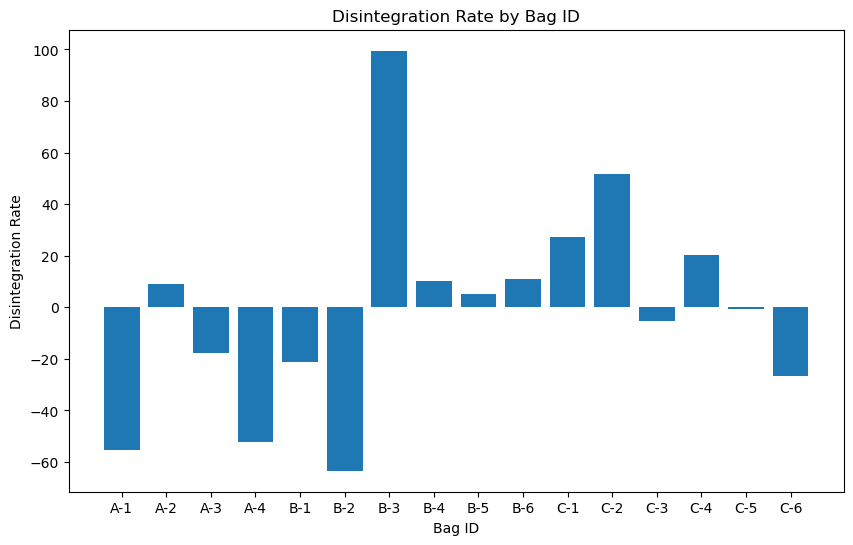

In [41]:
plt.figure(figsize=(10, 6))
plt.bar(disintegration_by_bag['bag_ID'], disintegration_by_bag['disintegration_rate'])
plt.xlabel('Bag ID')
plt.ylabel('Disintegration Rate') 
plt.title('Disintegration Rate by Bag ID')

In [42]:
disintegration_by_bag['bag_type'] = disintegration_by_bag['bag_ID'].str[0]
disintegration_by_bag_type = disintegration_by_bag.groupby('bag_type')['disintegration_rate'].mean()
disintegration_by_bag_type

bag_type
A   -29.131303
B      6.86755
C    11.077814
Name: disintegration_rate, dtype: object

5. Calculate the disintegration rate of the brand/manufacturer of the products

    Note: Some of the values have extra tailing spaces

In [25]:
list(df_product['product_brand'].unique())

['BÉSICS®',
 'BÉSICS® ',
 'Greenware® ',
 'No name',
 'World Centric™',
 'Sun & Swell/ Elevate',
 'Sun & Swell / Elevate',
 'Sun & Swell / TIPA',
 'Sun & Swell / Elk',
 nan]

In [26]:
# Remove extra spaces
df_product['product_brand'] = df_product['product_brand'].str.rstrip()

In [28]:
df_brand = filtered_data.merge(df_product[['product_name', 'product_brand']], on='product_name', how='left')
df_brand

,bag_ID,product_name,bag_intact_end,bag_intact_interval,bag_intact_start,bag_depth_end,bag_depth_interval,bag_depth_start,photo_available_end,photo_available_interval,photo_available_start,weight_mean_g_end,weight_mean_g_interval,weight_mean_g_start,product notes_end,product notes_interval,product notes_start,product_brand
0,A-1,12 oz Hot cup / Soup bowl,True,True,True,Top depth,Top depth,Top depth,NaN,NaN,Y,0.00,NaN,8.11,NaN,NaN,NaN,BÉSICS®
1,A-1,12 oz Hot cup / Soup bowl,True,True,True,Top depth,Top depth,Top depth,NaN,NaN,Y,0.00,NaN,8.11,NaN,NaN,NaN,BÉSICS®
2,A-1,16 oz PLA cold cup,True,True,True,Top depth,Top depth,Top depth,NaN,NaN,Y,0.00,NaN,14.58,NaN,NaN,NaN,Greenware®
3,A-1,16 oz PLA cold cup,True,True,True,Top depth,Top depth,Top depth,NaN,NaN,Y,0.00,NaN,14.58,NaN,NaN,NaN,Greenware®
4,A-1,Cutlery,True,True,True,Top depth,Top depth,Top depth,NaN,NaN,Y,0.00,NaN,4.75,NaN,NaN,NaN,BÉSICS®
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,C-6,Large natural clear colour bag,True,True,True,Bottom depth,Bottom depth,Bottom depth,Y,NaN,Y,8.97,NaN,8.4,Several items stuck together and not decompose...,NaN,NaN,Sun & Swell / Elk
304,C-6,Printed small bag with brown background and logo,True,True,True,Bottom depth,Bottom depth,Bottom depth,Y,NaN,Y,5.69,NaN,4.57,Several items stuck together and not decompose...,NaN,NaN,Sun & Swell / TIPA
305,C-6,Printed small bag with brown background and logo,True,True,True,Bottom depth,Bottom depth,Bottom depth,Y,NaN,Y,5.69,NaN,4.57,Several items stuck together and not decompose...,NaN,NaN,Sun & Swell / TIPA
306,C-6,Small zippered clear colour bag,True,True,True,Bottom depth,Bottom depth,Bottom depth,Y,NaN,Y,5.60,NaN,4.83,Several items stuck together and not decompose...,NaN,More detailed composition in word doc,Sun & Swell / Elevate


In [35]:
disintegration_by_brand = df_brand.groupby(['product_brand'], as_index=False)[['weight_mean_g_start', 'weight_mean_g_end']].mean()
disintegration_by_brand['disintegration_rate'] = (disintegration_by_brand['weight_mean_g_start'] - disintegration_by_brand['weight_mean_g_end'])/disintegration_by_brand['weight_mean_g_start'] * 100
disintegration_by_brand

,product_brand,weight_mean_g_start,weight_mean_g_end,disintegration_rate
0,BÉSICS®,11.43,16.143056,-41.234082
1,Greenware®,14.58,0.000000,100.0
2,No name,2.85,5.860833,-105.643275
3,Sun & Swell / Elevate,4.83,1.780000,63.146998
4,Sun & Swell / Elk,8.4,7.683333,8.531746
5,Sun & Swell / TIPA,4.57,4.670000,-2.188184
6,Sun & Swell/ Elevate,12.72,13.576667,-6.734801
7,World Centric™,11.624444,10.655062,8.339175


Text(0.5, 1.0, 'Disintegration Rate by Brand/Manufacturer')

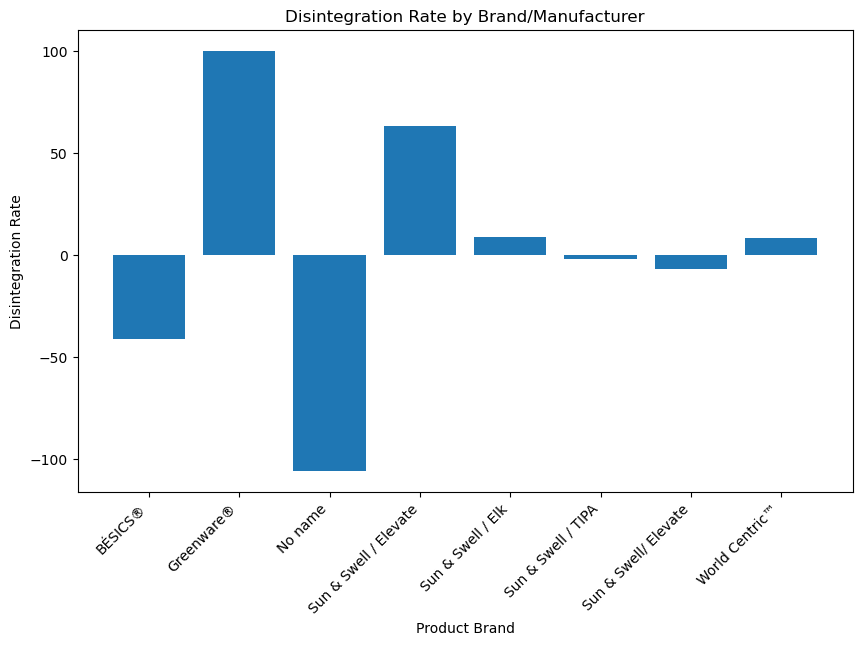

In [38]:
plt.figure(figsize=(10, 6))
plt.bar(disintegration_by_brand['product_brand'], disintegration_by_brand['disintegration_rate'])
plt.xlabel('Product Brand')
plt.xticks(rotation=45, ha="right") 
plt.ylabel('Disintegration Rate') 
plt.title('Disintegration Rate by Brand/Manufacturer')